<a href="https://colab.research.google.com/github/mdsiamahmed26/morphMan/blob/master/CT_DATA_Measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
print("="*70)
print("📦 INSTALLING REQUIRED PACKAGES")
print("="*70)

!pip install trimesh scipy scikit-learn matplotlib pandas seaborn plotly -q

print("\n✅ Installation complete!")


📦 INSTALLING REQUIRED PACKAGES
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.4/740.4 kB 7.6 MB/s eta 0:00:00

✅ Installation complete!


In [3]:
print("\n" + "="*70)
print("📚 IMPORTING LIBRARIES")
print("="*70)

import numpy as np
import trimesh
from scipy.spatial import KDTree
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

try:
    from google.colab import files
    import zipfile
    import os
    COLAB_ENV = True
    print("✅ Running in Google Colab")
except:
    COLAB_ENV = False
    print("⚠️ Not running in Colab - file upload will be skipped")

print("✅ All libraries imported successfully!")


📚 IMPORTING LIBRARIES
✅ Running in Google Colab
✅ All libraries imported successfully!


In [4]:
print("\n" + "="*70)
print("🔧 DEFINING ANALYZER CLASS")
print("="*70)

class VesselGeometryAnalyzer:
    """
    Complete vessel geometry analyzer for STL files
    Measures: Bifurcation Angle, Curvature, Roughness, Stenosis
    """

    def __init__(self, stl_file_path):
        """Initialize analyzer with STL file"""
        print(f"\n📂 Loading STL file: {stl_file_path}")
        self.mesh = trimesh.load_mesh(stl_file_path)
        print(f"✅ Mesh loaded: {len(self.mesh.vertices)} vertices, {len(self.mesh.faces)} faces")

        if not self.mesh.is_watertight:
            print("⚠️  Mesh is not watertight - attempting to fix...")
            self.mesh.fill_holes()

        self.centerline = None
        self.cross_sections = None
        self.file_name = Path(stl_file_path).name

    def extract_centerline(self, num_points=100):
        """Extract centerline from vessel mesh using medial axis approximation"""
        print("\n📍 Extracting centerline...")

        bounds = self.mesh.bounds
        dimensions = bounds[1] - bounds[0]
        main_axis = np.argmax(dimensions)

        axis_min = bounds[0, main_axis]
        axis_max = bounds[1, main_axis]
        axis_samples = np.linspace(axis_min, axis_max, num_points)

        centerline_points = []

        for sample in axis_samples:
            if main_axis == 0:
                mask = np.abs(self.mesh.vertices[:, 0] - sample) < 0.5
            elif main_axis == 1:
                mask = np.abs(self.mesh.vertices[:, 1] - sample) < 0.5
            else:
                mask = np.abs(self.mesh.vertices[:, 2] - sample) < 0.5

            if np.any(mask):
                section_points = self.mesh.vertices[mask]
                center = np.mean(section_points, axis=0)
                centerline_points.append(center)

        self.centerline = np.array(centerline_points)

        # Smooth centerline
        for i in range(3):
            self.centerline[:, i] = gaussian_filter1d(self.centerline[:, i], sigma=2)

        print(f"✅ Centerline extracted: {len(self.centerline)} points")
        return self.centerline

    def calculate_bifurcation_angle(self):
        """
        Calculate bifurcation angle from vessel geometry
        Uses maximum curvature region to estimate bifurcation
        """
        print("\n🔀 Calculating bifurcation angle...")

        if self.centerline is None:
            self.extract_centerline()

        # Calculate tangent vectors along centerline
        tangent_vectors = np.gradient(self.centerline, axis=0)

        # Normalize tangent vectors
        tangent_norms = np.linalg.norm(tangent_vectors, axis=1, keepdims=True)
        tangent_norms[tangent_norms < 1e-10] = 1e-10
        tangent_normalized = tangent_vectors / tangent_norms

        # Calculate angle changes
        angles = []
        for i in range(1, len(tangent_normalized)):
            cos_angle = np.dot(tangent_normalized[i], tangent_normalized[i-1])
            cos_angle = np.clip(cos_angle, -1.0, 1.0)
            angle = np.arccos(cos_angle)
            angles.append(np.degrees(angle))

        angles = np.array(angles)

        if len(angles) > 10:
            # Smooth angles
            angles_smooth = gaussian_filter1d(angles, sigma=2)

            # Find bifurcation region (largest angle change)
            bifurcation_idx = np.argmax(angles_smooth)
            max_single_angle = angles_smooth[bifurcation_idx]

            # Calculate cumulative angle over bifurcation region
            window = 5
            if bifurcation_idx > window and bifurcation_idx < len(angles) - window:
                cumulative_angle = np.sum(angles_smooth[bifurcation_idx-window:bifurcation_idx+window])
            else:
                cumulative_angle = max_single_angle

            # Estimate bifurcation angle (clamp to realistic range)
            estimated_angle = min(cumulative_angle, 90.0)
        else:
            max_single_angle = np.max(angles) if len(angles) > 0 else 0
            cumulative_angle = np.sum(angles) if len(angles) > 0 else 0
            estimated_angle = min(cumulative_angle, 90.0)

        results = {
            'bifurcation_angle': estimated_angle,
            'max_angle_change': max_single_angle,
            'total_angle': cumulative_angle,
            'angles_array': angles
        }

        print(f"✅ Bifurcation Angle: {estimated_angle:.2f}°")
        print(f"   Max angle change: {max_single_angle:.2f}°")

        return results

    def calculate_curvature(self):
        """Calculate curvature along centerline"""
        if self.centerline is None:
            self.extract_centerline()

        print("\n📐 Calculating curvature...")

        # First derivative (tangent)
        tangent = np.gradient(self.centerline, axis=0)

        # Second derivative
        d2x = np.gradient(tangent[:, 0])
        d2y = np.gradient(tangent[:, 1])
        d2z = np.gradient(tangent[:, 2])

        # Curvature: κ = |r' × r''| / |r'|³
        cross_product = np.cross(tangent, np.column_stack([d2x, d2y, d2z]))
        numerator = np.linalg.norm(cross_product, axis=1)
        denominator = np.linalg.norm(tangent, axis=1)**3
        denominator[denominator < 1e-10] = 1e-10

        curvature = numerator / denominator
        curvature = curvature[5:-5]  # Remove outliers at endpoints

        results = {
            'max_curvature': np.max(curvature),
            'mean_curvature': np.mean(curvature),
            'median_curvature': np.median(curvature),
            'std_curvature': np.std(curvature),
            'curvature_array': curvature
        }

        print(f"✅ Max Curvature:  {results['max_curvature']:.6f} mm⁻¹")
        print(f"   Mean Curvature: {results['mean_curvature']:.6f} mm⁻¹")

        return results

    def calculate_surface_roughness(self, sample_size=5000):
        """Calculate surface roughness using local plane fitting"""
        print("\n🔍 Calculating surface roughness...")

        # Sample points from mesh
        if len(self.mesh.vertices) > sample_size:
            indices = np.random.choice(len(self.mesh.vertices), sample_size, replace=False)
            sample_points = self.mesh.vertices[indices]
        else:
            sample_points = self.mesh.vertices

        tree = KDTree(sample_points)
        deviations = []

        # Calculate deviation for each point
        for point in sample_points:
            radius = 2.0  # mm
            indices = tree.query_ball_point(point, radius)

            if len(indices) > 10:
                neighbors = sample_points[indices]

                # Fit local plane using PCA
                pca = PCA(n_components=3)
                pca.fit(neighbors - point)
                normal = pca.components_[2]

                # Calculate deviation from plane
                centroid = np.mean(neighbors, axis=0)
                deviation = np.abs(np.dot(point - centroid, normal))
                deviations.append(deviation)

        deviations = np.array(deviations)

        # Remove outliers (top 5%)
        threshold = np.percentile(deviations, 95)
        deviations = deviations[deviations < threshold]

        results = {
            'Ra': np.mean(np.abs(deviations)),  # Arithmetic average
            'Rq': np.sqrt(np.mean(deviations**2)),  # RMS roughness
            'Rt': np.max(deviations) - np.min(deviations),  # Peak-to-valley
            'roughness_array': deviations
        }

        print(f"✅ Ra (Arithmetic): {results['Ra']:.6f} mm")
        print(f"   Rq (RMS):        {results['Rq']:.6f} mm")

        return results

    def calculate_stenosis_severity(self):
        """Calculate stenosis severity from cross-sectional area changes"""
        if self.centerline is None:
            self.extract_centerline()

        print("\n💔 Calculating stenosis severity...")

        areas = []
        diameters = []

        for i, point in enumerate(self.centerline):
            # Calculate tangent direction
            if i == 0:
                tangent = self.centerline[1] - point
            elif i == len(self.centerline) - 1:
                tangent = point - self.centerline[-2]
            else:
                tangent = self.centerline[i+1] - self.centerline[i-1]

            tangent = tangent / np.linalg.norm(tangent)

            # Find cross-section
            tolerance = 0.5
            distances = np.abs(np.dot(self.mesh.vertices - point, tangent))
            mask = distances < tolerance

            if np.sum(mask) > 3:
                section_points = self.mesh.vertices[mask]
                projected = section_points - np.outer(np.dot(section_points - point, tangent), tangent)
                radii = np.linalg.norm(projected - point, axis=1)
                max_radius = np.max(radii)

                area = np.pi * max_radius**2
                diameter = 2 * max_radius

                areas.append(area)
                diameters.append(diameter)

        areas = np.array(areas)
        diameters = np.array(diameters)

        # Smooth curves
        if len(areas) > 10:
            areas_smooth = gaussian_filter1d(areas, sigma=2)
            diameters_smooth = gaussian_filter1d(diameters, sigma=2)
        else:
            areas_smooth = areas
            diameters_smooth = diameters

        # Calculate stenosis
        min_area = np.min(areas_smooth)
        min_diameter = np.min(diameters_smooth)

        # Reference from proximal segment (first 25%)
        proximal_length = len(areas_smooth) // 4
        reference_area = np.mean(areas_smooth[:proximal_length])
        reference_diameter = np.mean(diameters_smooth[:proximal_length])

        area_stenosis = ((reference_area - min_area) / reference_area) * 100
        diameter_stenosis = ((reference_diameter - min_diameter) / reference_diameter) * 100

        results = {
            'area_stenosis_percent': area_stenosis,
            'diameter_stenosis_percent': diameter_stenosis,
            'min_area': min_area,
            'reference_area': reference_area,
            'min_diameter': min_diameter,
            'reference_diameter': reference_diameter,
            'areas_array': areas_smooth,
            'diameters_array': diameters_smooth
        }

        print(f"✅ Area Stenosis:     {area_stenosis:.2f}%")
        print(f"   Diameter Stenosis: {diameter_stenosis:.2f}%")

        return results

    def visualize_results(self, bifurcation_data, curvature_data, roughness_data, stenosis_data):
        """Create comprehensive visualization"""
        fig = plt.figure(figsize=(20, 12))
        fig.suptitle(f'Vessel Analysis: {self.file_name}', fontsize=16, fontweight='bold')

        # 1. 3D mesh with centerline
        ax1 = fig.add_subplot(2, 4, 1, projection='3d')
        ax1.plot_trisurf(self.mesh.vertices[:, 0],
                        self.mesh.vertices[:, 1],
                        self.mesh.faces,
                        self.mesh.vertices[:, 2],
                        alpha=0.3, color='lightblue', edgecolor='none')

        if self.centerline is not None:
            ax1.plot(self.centerline[:, 0],
                    self.centerline[:, 1],
                    self.centerline[:, 2],
                    'r-', linewidth=3, label='Centerline')

        ax1.set_xlabel('X (mm)')
        ax1.set_ylabel('Y (mm)')
        ax1.set_zlabel('Z (mm)')
        ax1.set_title('Vessel Geometry', fontweight='bold')
        ax1.legend()

        # 2. Bifurcation angle profile
        ax2 = fig.add_subplot(2, 4, 2)
        if 'angles_array' in bifurcation_data and len(bifurcation_data['angles_array']) > 0:
            angles = bifurcation_data['angles_array']
            ax2.plot(angles, 'purple', linewidth=2)
            ax2.axhline(y=bifurcation_data['bifurcation_angle'],
                       color='r', linestyle='--', linewidth=2,
                       label=f"Bifurc: {bifurcation_data['bifurcation_angle']:.1f}°")
            ax2.fill_between(range(len(angles)), angles, alpha=0.3, color='purple')
        ax2.set_xlabel('Position')
        ax2.set_ylabel('Angle Change (°)')
        ax2.set_title('Bifurcation Angle', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        # 3. Curvature profile
        ax3 = fig.add_subplot(2, 4, 3)
        curvature = curvature_data['curvature_array']
        ax3.plot(curvature, 'b-', linewidth=2)
        ax3.axhline(y=curvature_data['mean_curvature'],
                   color='r', linestyle='--', linewidth=2,
                   label=f"Mean: {curvature_data['mean_curvature']:.4f}")
        ax3.fill_between(range(len(curvature)), curvature, alpha=0.3)
        ax3.set_xlabel('Point Index')
        ax3.set_ylabel('Curvature (mm⁻¹)')
        ax3.set_title('LMS Curvature', fontweight='bold')
        ax3.grid(True, alpha=0.3)
        ax3.legend()

        # 4. Stenosis area
        ax4 = fig.add_subplot(2, 4, 4)
        areas = stenosis_data['areas_array']
        ax4.plot(areas, 'g-', linewidth=2)
        ax4.axhline(y=stenosis_data['reference_area'],
                   color='b', linestyle='--', linewidth=2,
                   label=f"Ref: {stenosis_data['reference_area']:.2f}")
        ax4.axhline(y=stenosis_data['min_area'],
                   color='r', linestyle='--', linewidth=2,
                   label=f"Min: {stenosis_data['min_area']:.2f}")
        ax4.fill_between(range(len(areas)), areas, alpha=0.3, color='green')
        ax4.set_xlabel('Position')
        ax4.set_ylabel('Area (mm²)')
        ax4.set_title(f"Stenosis: {stenosis_data['area_stenosis_percent']:.1f}%", fontweight='bold')
        ax4.grid(True, alpha=0.3)
        ax4.legend()

        # 5. Diameter profile
        ax5 = fig.add_subplot(2, 4, 5)
        diameters = stenosis_data['diameters_array']
        ax5.plot(diameters, 'm-', linewidth=2)
        ax5.axhline(y=stenosis_data['reference_diameter'],
                   color='b', linestyle='--', linewidth=2)
        ax5.fill_between(range(len(diameters)), diameters, alpha=0.3, color='magenta')
        ax5.set_xlabel('Position')
        ax5.set_ylabel('Diameter (mm)')
        ax5.set_title('Vessel Diameter', fontweight='bold')
        ax5.grid(True, alpha=0.3)

        # 6. Curvature histogram
        ax6 = fig.add_subplot(2, 4, 6)
        ax6.hist(curvature_data['curvature_array'], bins=30,
                color='blue', alpha=0.7, edgecolor='black')
        ax6.axvline(x=curvature_data['mean_curvature'],
                   color='r', linestyle='--', linewidth=2)
        ax6.set_xlabel('Curvature (mm⁻¹)')
        ax6.set_ylabel('Frequency')
        ax6.set_title('Curvature Distribution', fontweight='bold')
        ax6.grid(True, alpha=0.3)

        # 7. Roughness histogram
        ax7 = fig.add_subplot(2, 4, 7)
        ax7.hist(roughness_data['roughness_array'], bins=30,
                color='green', alpha=0.7, edgecolor='black')
        ax7.axvline(x=roughness_data['Ra'],
                   color='r', linestyle='--', linewidth=2)
        ax7.set_xlabel('Deviation (mm)')
        ax7.set_ylabel('Frequency')
        ax7.set_title('Roughness Distribution', fontweight='bold')
        ax7.grid(True, alpha=0.3)

        # 8. Summary text box
        ax8 = fig.add_subplot(2, 4, 8)
        ax8.axis('off')

        summary = f"""📊 4-FACTOR MEASUREMENTS
{'='*40}

🔀 Bifurcation Angle:
   {bifurcation_data['bifurcation_angle']:.2f}°

📐 LMS Curvature:
   Mean: {curvature_data['mean_curvature']:.6f} mm⁻¹
   Max:  {curvature_data['max_curvature']:.6f} mm⁻¹

🔍 LMS Roughness:
   Ra: {roughness_data['Ra']:.6f} mm
   Rq: {roughness_data['Rq']:.6f} mm

💔 Stenosis Severity:
   Area: {stenosis_data['area_stenosis_percent']:.2f}%
   Diam: {stenosis_data['diameter_stenosis_percent']:.2f}%
"""

        ax8.text(0.1, 0.9, summary,
                verticalalignment='top',
                fontfamily='monospace',
                fontsize=10,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

        plt.tight_layout()
        plt.savefig(f'analysis_{self.file_name.replace(".stl", "")}.png',
                   dpi=150, bbox_inches='tight')
        plt.show()

    def analyze_all(self):
        """Perform complete 4-factor analysis"""
        print("\n" + "="*70)
        print("🔬 COMPLETE 4-FACTOR VESSEL ANALYSIS")
        print("="*70)

        self.extract_centerline(num_points=100)
        bifurcation_results = self.calculate_bifurcation_angle()
        curvature_results = self.calculate_curvature()
        roughness_results = self.calculate_surface_roughness()
        stenosis_results = self.calculate_stenosis_severity()

        results = {
            'bifurcation': bifurcation_results,
            'curvature': curvature_results,
            'roughness': roughness_results,
            'stenosis': stenosis_results
        }

        self.visualize_results(bifurcation_results, curvature_results,
                             roughness_results, stenosis_results)

        return results

print("✅ VesselGeometryAnalyzer class ready!")



🔧 DEFINING ANALYZER CLASS
✅ VesselGeometryAnalyzer class ready!


In [5]:
print("\n" + "="*70)
print("📤 UPLOAD YOUR STL FILES")
print("="*70)

if COLAB_ENV:
    print("\n📁 Click 'Choose Files' and select your STL files...")
    print("   (You can select multiple files)")
    uploaded = files.upload()
    print(f"\n✅ {len(uploaded)} file(s) uploaded!")
else:
    print("⚠️ Not in Colab - using example mode")
    uploaded = {}



📤 UPLOAD YOUR STL FILES

📁 Click 'Choose Files' and select your STL files...
   (You can select multiple files)


Saving patient3.stl to patient3.stl
Saving patient6.stl to patient6.stl
Saving patient7.stl to patient7.stl
Saving patient8.stl to patient8.stl
Saving patient10.stl to patient10.stl

✅ 5 file(s) uploaded!



🔬 ANALYZING ALL PATIENTS

📊 PATIENT: patient3.stl

📂 Loading STL file: patient3.stl
✅ Mesh loaded: 453428 vertices, 906852 faces

🔬 COMPLETE 4-FACTOR VESSEL ANALYSIS

📍 Extracting centerline...
✅ Centerline extracted: 100 points

🔀 Calculating bifurcation angle...
✅ Bifurcation Angle: 11.86°
   Max angle change: 11.86°

📐 Calculating curvature...
✅ Max Curvature:  0.319756 mm⁻¹
   Mean Curvature: 0.105994 mm⁻¹

🔍 Calculating surface roughness...
✅ Ra (Arithmetic): 0.291253 mm
   Rq (RMS):        0.317158 mm

💔 Calculating stenosis severity...
✅ Area Stenosis:     30.14%
   Diameter Stenosis: 16.62%


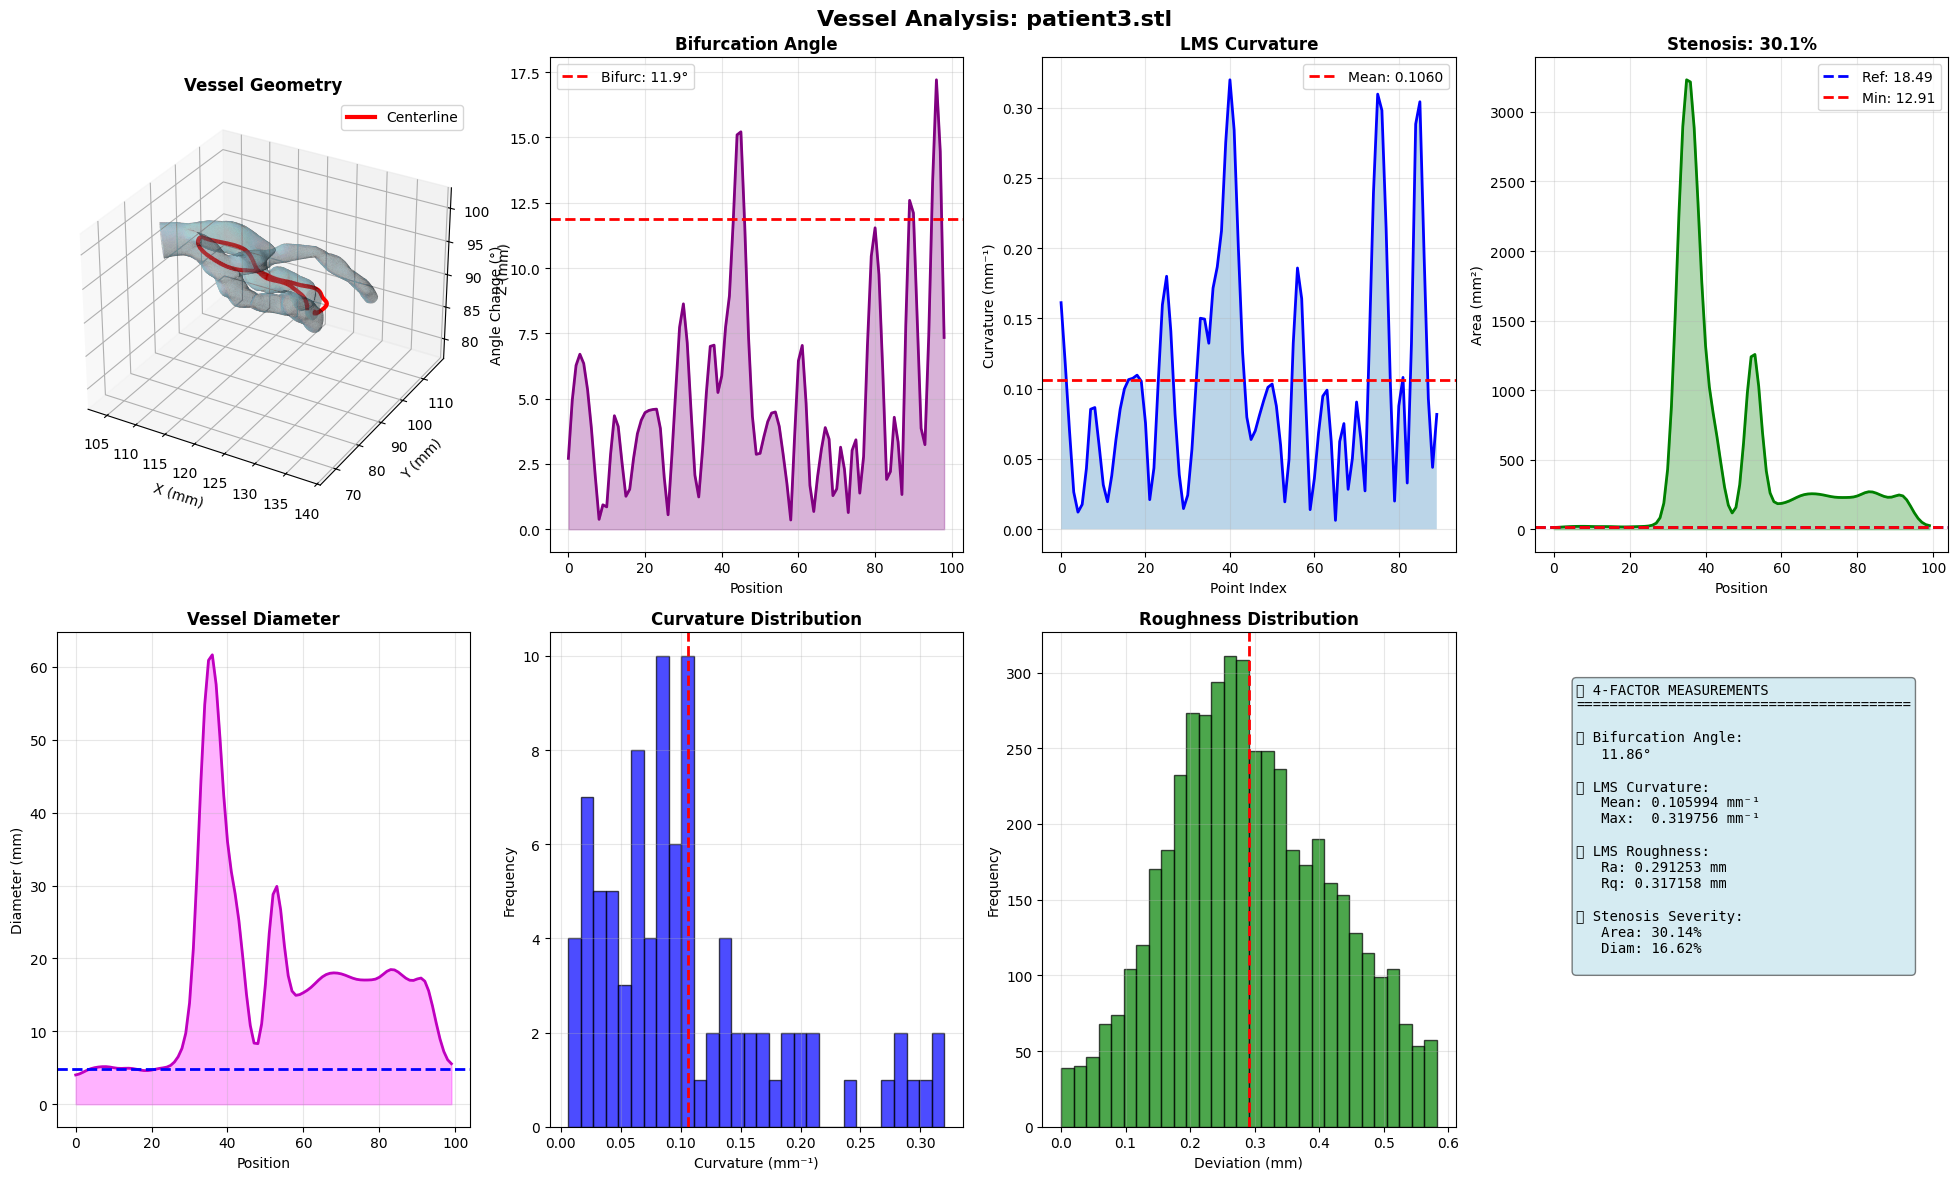


✅ patient3.stl - COMPLETE!

📊 PATIENT: patient6.stl

📂 Loading STL file: patient6.stl
✅ Mesh loaded: 83430 vertices, 166856 faces

🔬 COMPLETE 4-FACTOR VESSEL ANALYSIS

📍 Extracting centerline...
✅ Centerline extracted: 100 points

🔀 Calculating bifurcation angle...
✅ Bifurcation Angle: 90.00°
   Max angle change: 15.82°

📐 Calculating curvature...
✅ Max Curvature:  0.826841 mm⁻¹
   Mean Curvature: 0.093986 mm⁻¹

🔍 Calculating surface roughness...
✅ Ra (Arithmetic): 0.279483 mm
   Rq (RMS):        0.296429 mm

💔 Calculating stenosis severity...
✅ Area Stenosis:     18.83%
   Diameter Stenosis: 9.55%


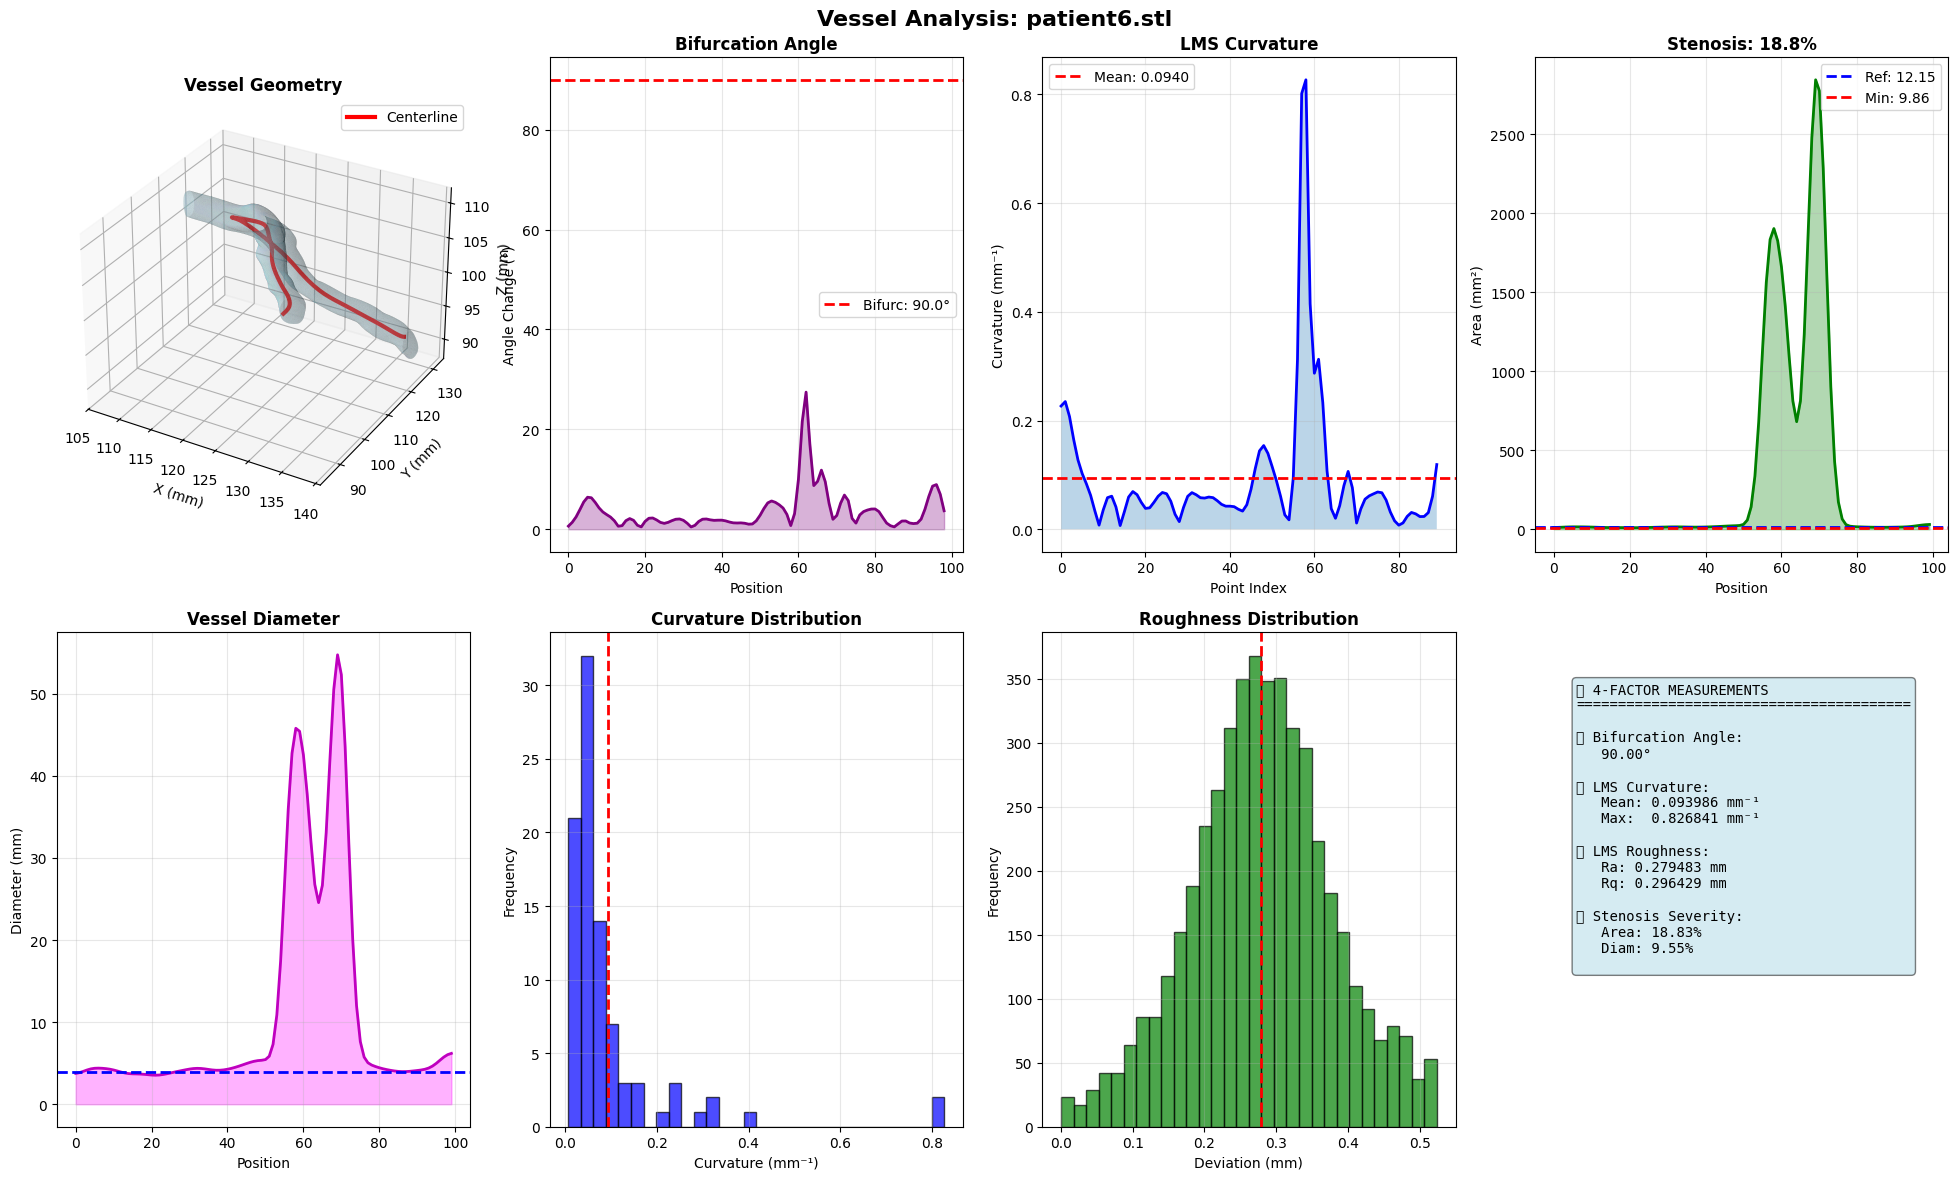


✅ patient6.stl - COMPLETE!

📊 PATIENT: patient7.stl

📂 Loading STL file: patient7.stl
✅ Mesh loaded: 26742 vertices, 53480 faces

🔬 COMPLETE 4-FACTOR VESSEL ANALYSIS

📍 Extracting centerline...
✅ Centerline extracted: 100 points

🔀 Calculating bifurcation angle...
✅ Bifurcation Angle: 90.00°
   Max angle change: 21.11°

📐 Calculating curvature...
✅ Max Curvature:  1.988858 mm⁻¹
   Mean Curvature: 0.214602 mm⁻¹

🔍 Calculating surface roughness...
✅ Ra (Arithmetic): 0.445923 mm
   Rq (RMS):        0.464450 mm

💔 Calculating stenosis severity...
✅ Area Stenosis:     97.69%
   Diameter Stenosis: 80.70%


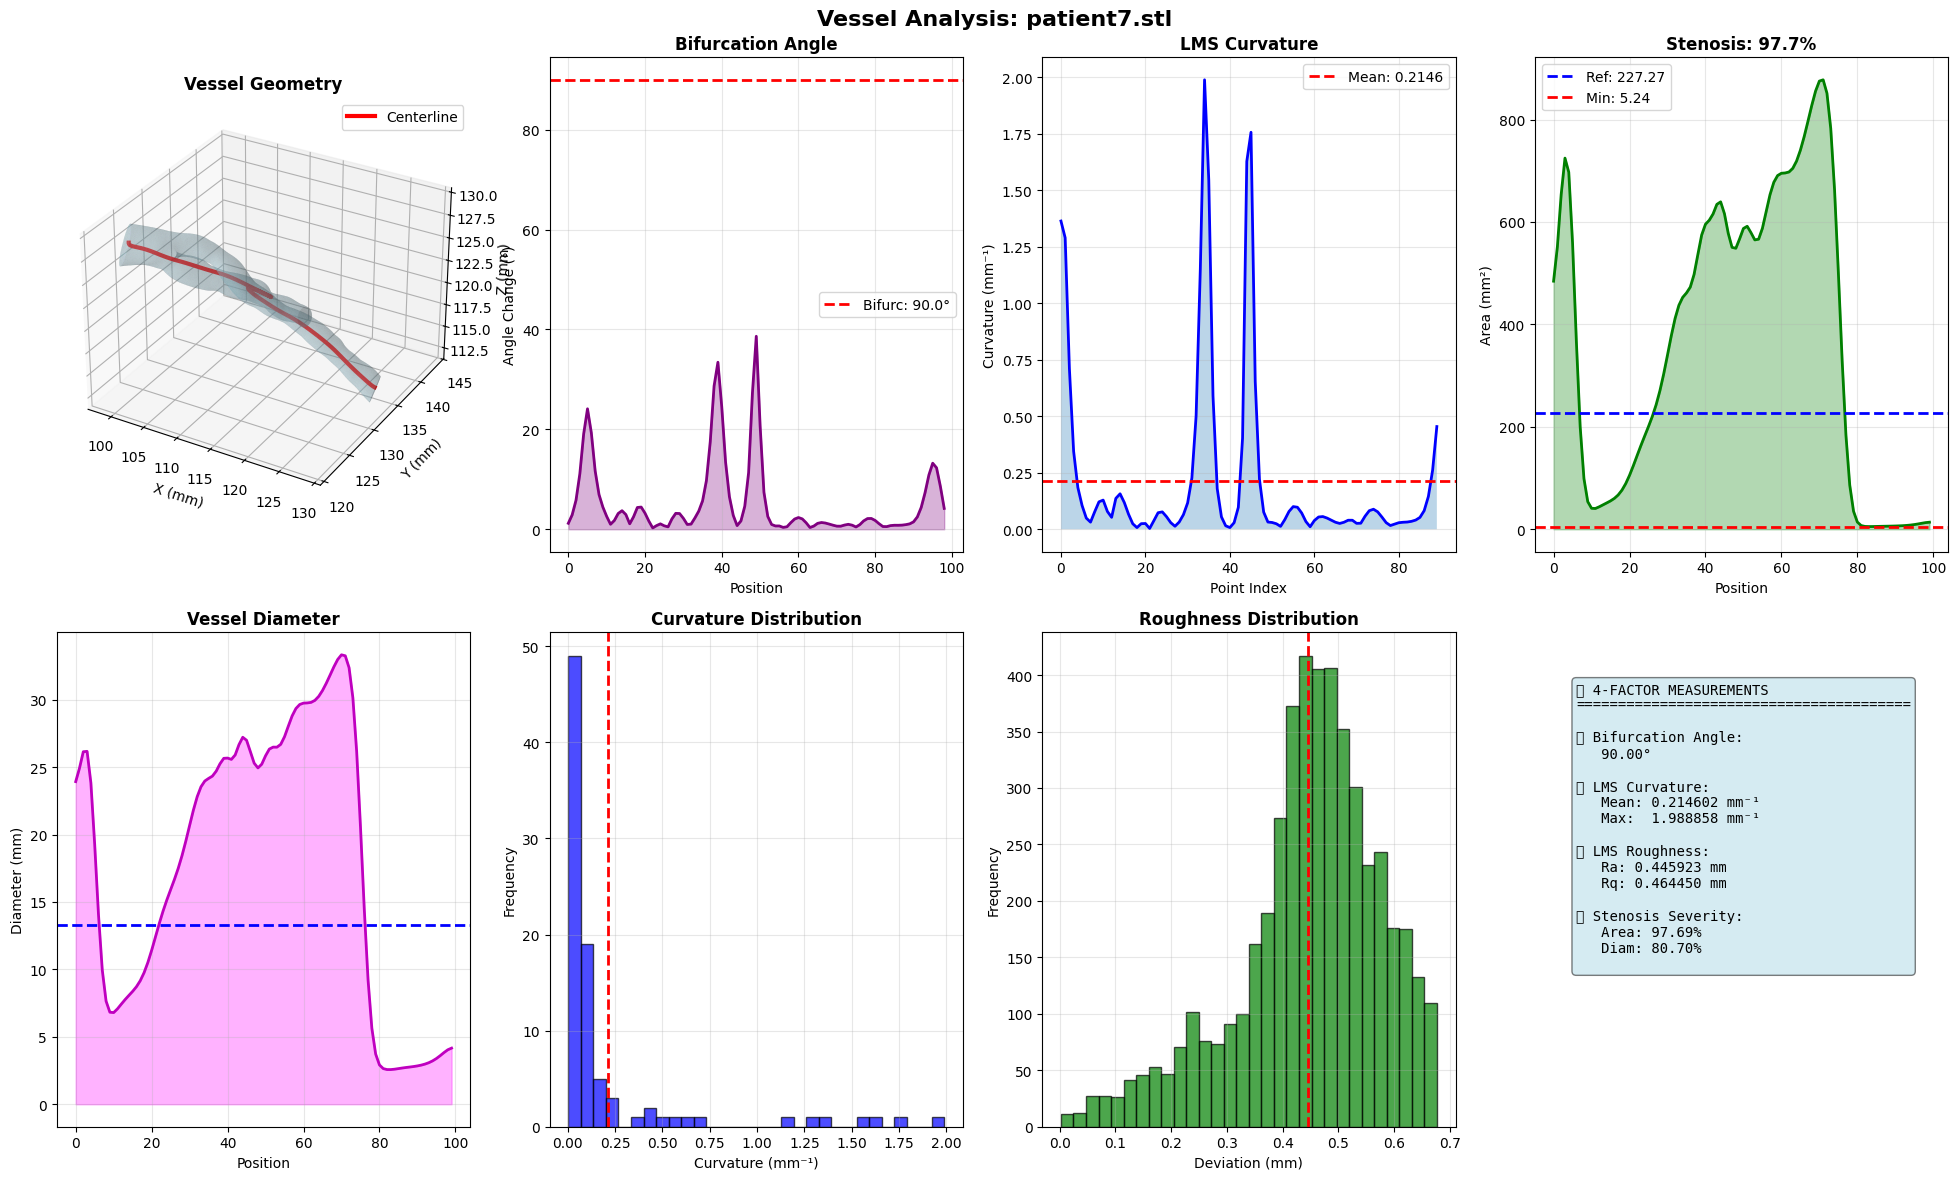


✅ patient7.stl - COMPLETE!

📊 PATIENT: patient8.stl

📂 Loading STL file: patient8.stl
✅ Mesh loaded: 56822 vertices, 113640 faces

🔬 COMPLETE 4-FACTOR VESSEL ANALYSIS

📍 Extracting centerline...
✅ Centerline extracted: 100 points

🔀 Calculating bifurcation angle...
✅ Bifurcation Angle: 90.00°
   Max angle change: 19.51°

📐 Calculating curvature...
✅ Max Curvature:  0.931618 mm⁻¹
   Mean Curvature: 0.104262 mm⁻¹

🔍 Calculating surface roughness...
✅ Ra (Arithmetic): 0.244222 mm
   Rq (RMS):        0.263996 mm

💔 Calculating stenosis severity...
✅ Area Stenosis:     44.83%
   Diameter Stenosis: 25.04%


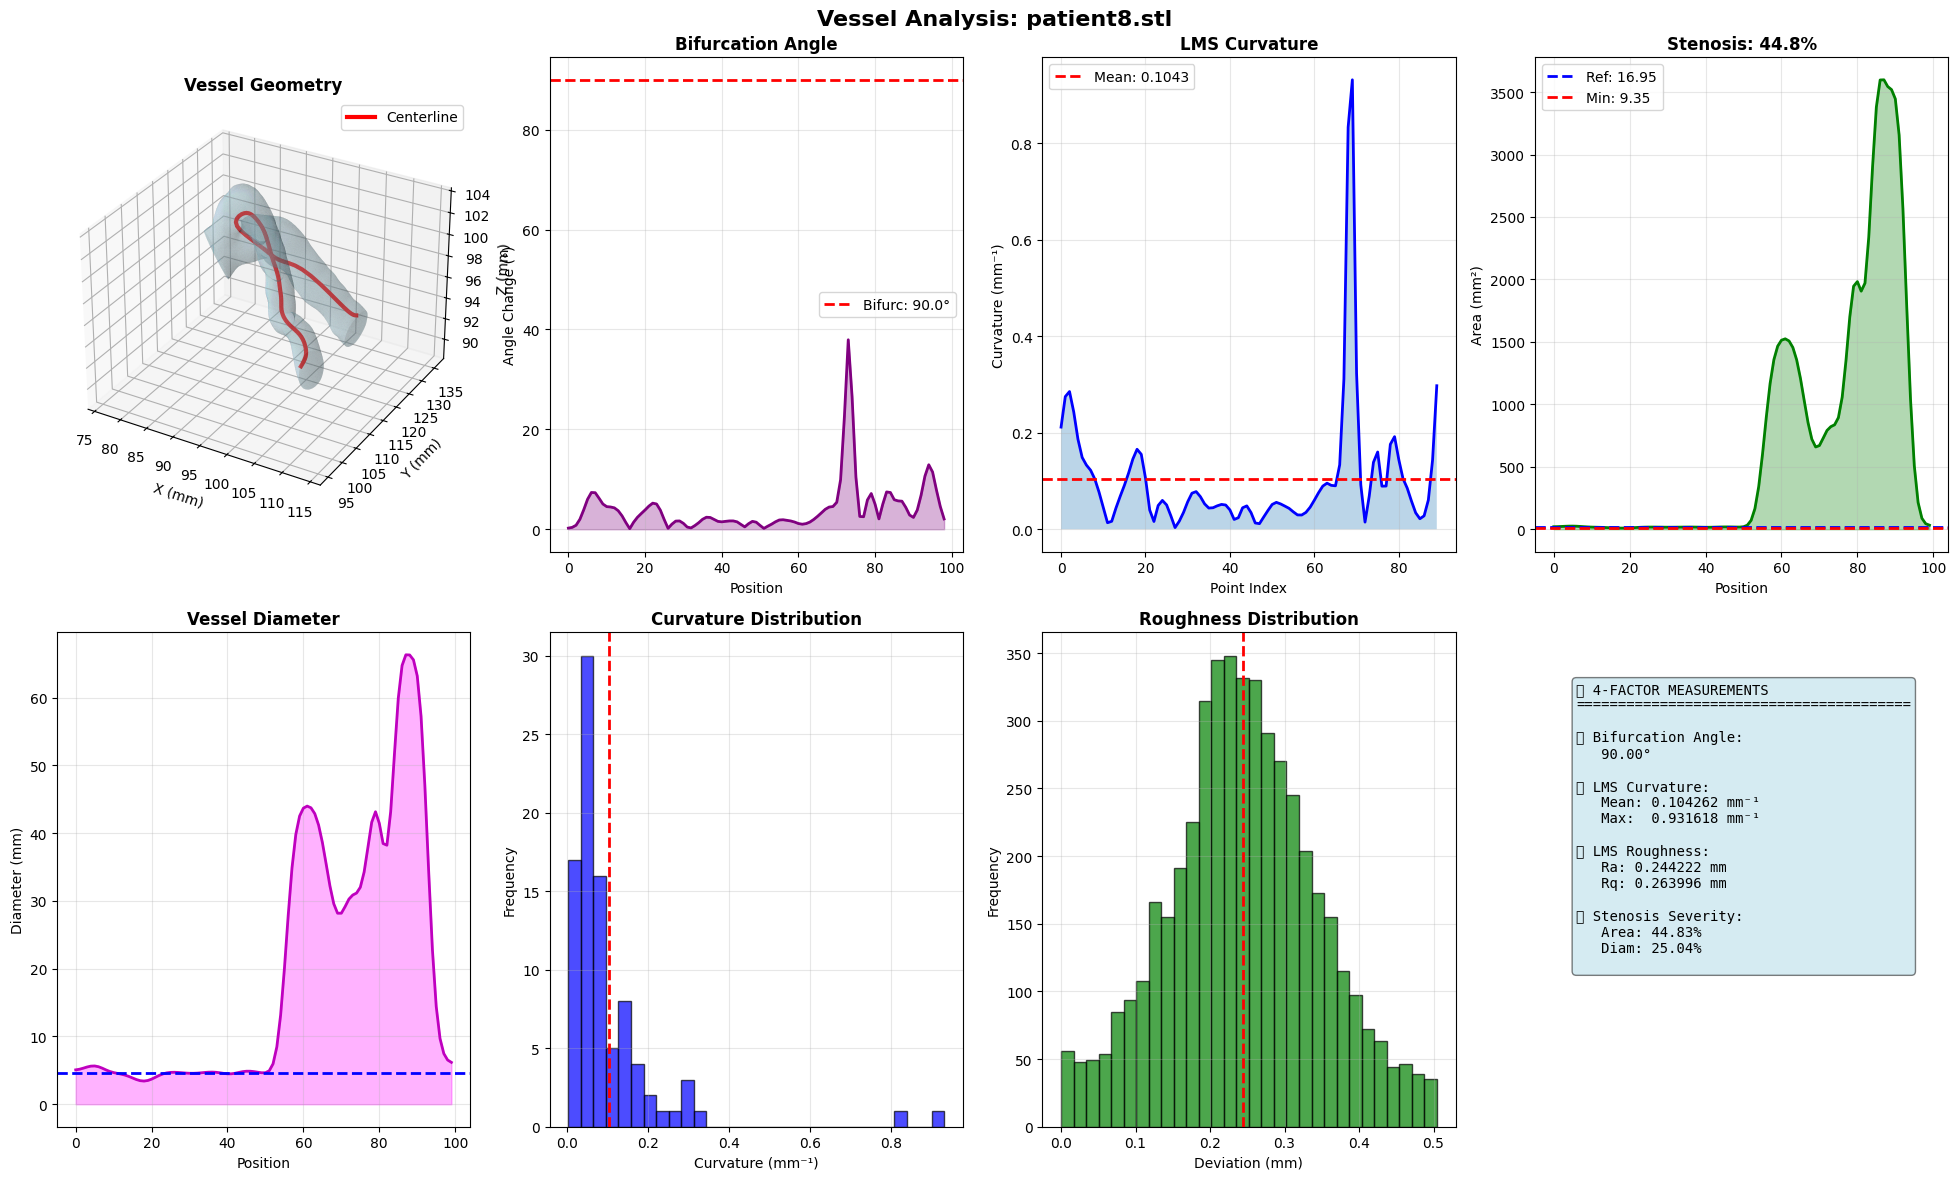


✅ patient8.stl - COMPLETE!

📊 PATIENT: patient10.stl

📂 Loading STL file: patient10.stl
✅ Mesh loaded: 125247 vertices, 250490 faces

🔬 COMPLETE 4-FACTOR VESSEL ANALYSIS

📍 Extracting centerline...
✅ Centerline extracted: 100 points

🔀 Calculating bifurcation angle...
✅ Bifurcation Angle: 90.00°
   Max angle change: 19.38°

📐 Calculating curvature...
✅ Max Curvature:  0.612766 mm⁻¹
   Mean Curvature: 0.086408 mm⁻¹

🔍 Calculating surface roughness...
✅ Ra (Arithmetic): 0.264123 mm
   Rq (RMS):        0.294793 mm

💔 Calculating stenosis severity...
✅ Area Stenosis:     74.77%
   Diameter Stenosis: 29.57%


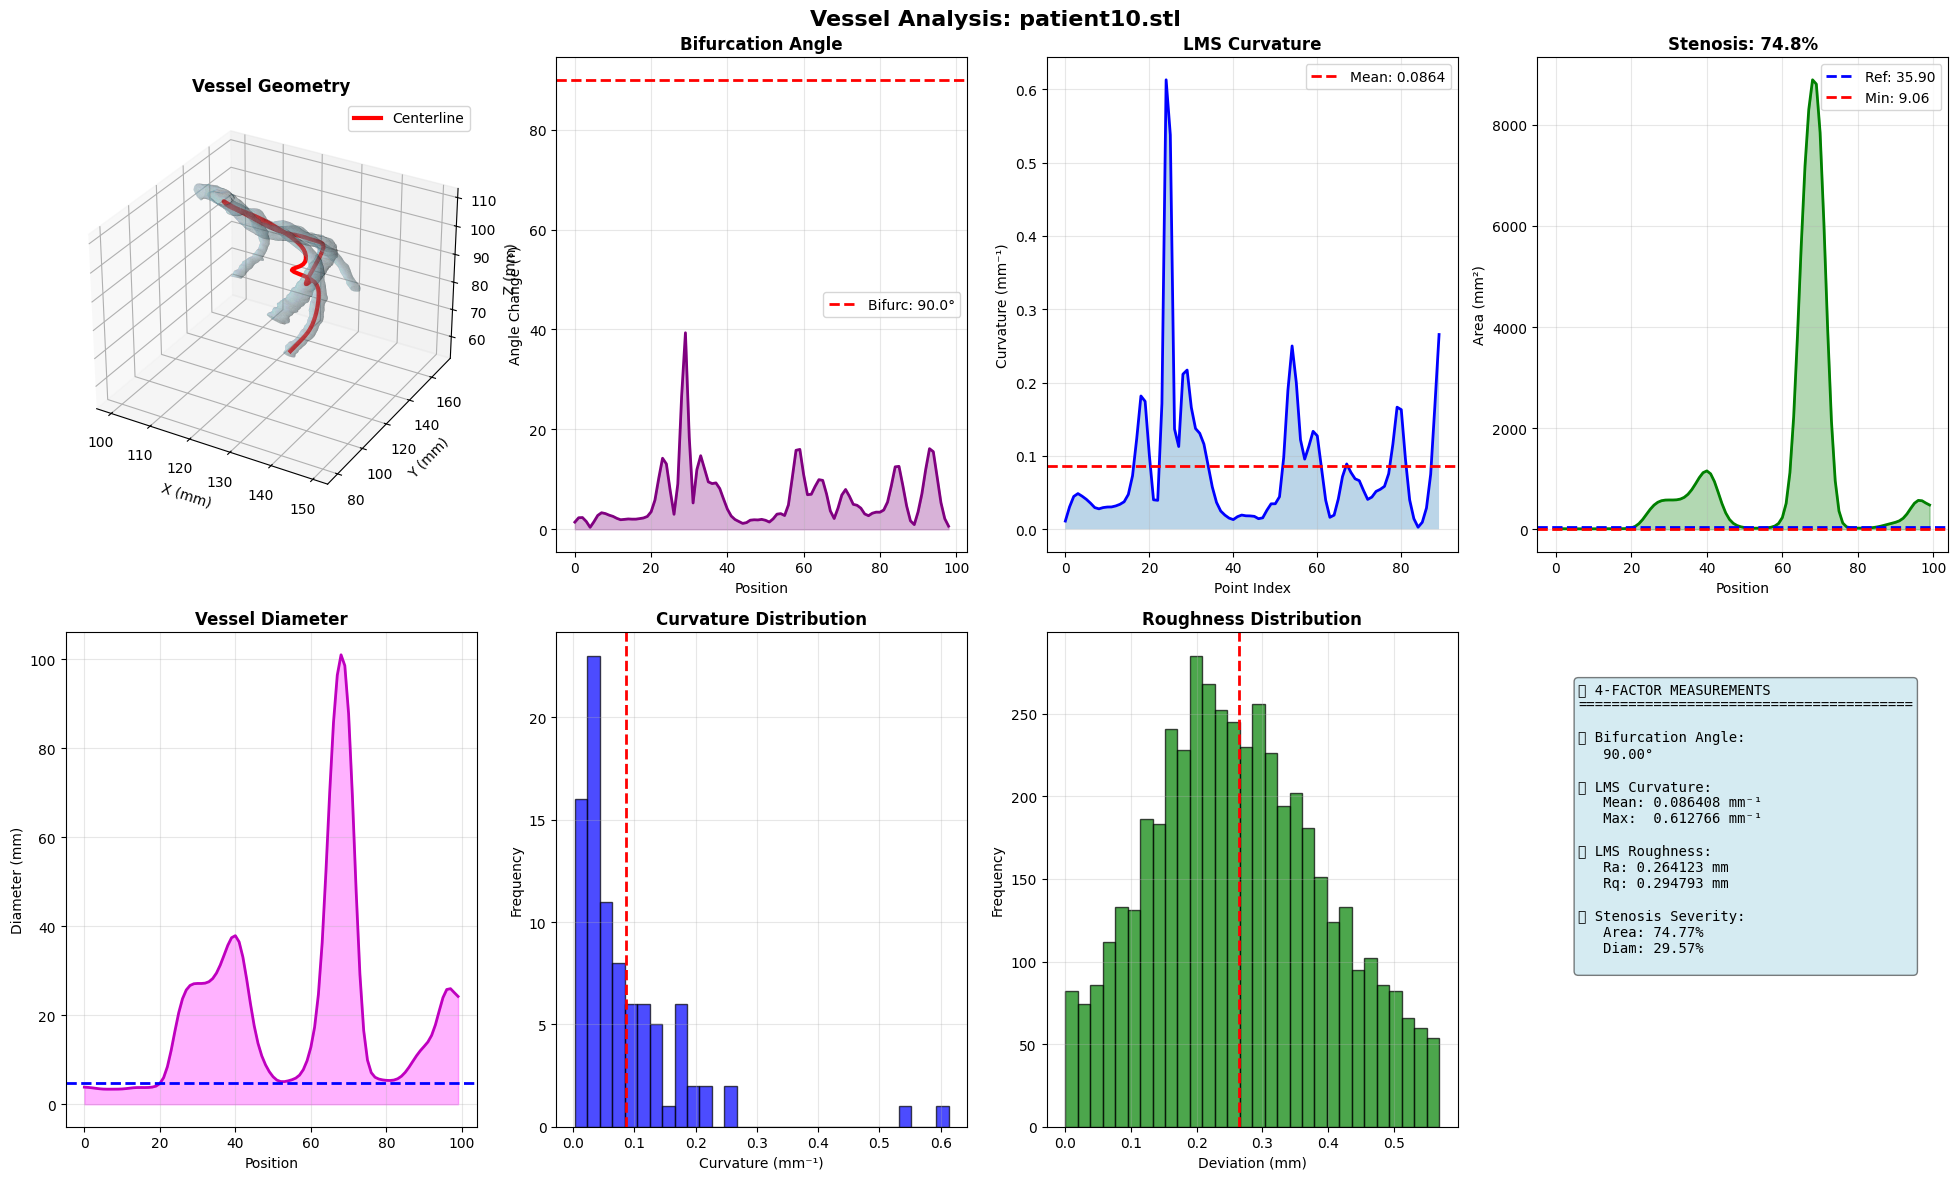


✅ patient10.stl - COMPLETE!

✅ ALL ANALYSES COMPLETE


In [6]:
print("\n" + "="*70)
print("🔬 ANALYZING ALL PATIENTS")
print("="*70)

all_results = []
patient_data = []

for filename in uploaded.keys():
    print(f"\n{'='*70}")
    print(f"📊 PATIENT: {filename}")
    print(f"{'='*70}")

    try:
        analyzer = VesselGeometryAnalyzer(filename)
        results = analyzer.analyze_all()

        patient_id = filename.replace('.stl', '')

        all_results.append({
            'patient_id': patient_id,
            'filename': filename,
            'results': results,
            'success': True
        })

        patient_data.append({
            'Patient_ID': patient_id,
            'Bifurcation_Angle': results['bifurcation']['bifurcation_angle'],
            'LMS_Curvature_Mean': results['curvature']['mean_curvature'],
            'LMS_Curvature_Max': results['curvature']['max_curvature'],
            'LMS_Roughness_Ra': results['roughness']['Ra'],
            'LMS_Roughness_Rq': results['roughness']['Rq'],
            'Stenosis_Area_Percent': results['stenosis']['area_stenosis_percent'],
            'Stenosis_Diameter_Percent': results['stenosis']['diameter_stenosis_percent'],
            'Min_Diameter_mm': results['stenosis']['min_diameter'],
            'Reference_Diameter_mm': results['stenosis']['reference_diameter']
        })

        print(f"\n✅ {filename} - COMPLETE!")

    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        all_results.append({
            'patient_id': filename.replace('.stl', ''),
            'filename': filename,
            'success': False,
            'error': str(e)
        })

print("\n" + "="*70)
print("✅ ALL ANALYSES COMPLETE")
print("="*70)

In [7]:
print("\n" + "="*70)
print("📊 CREATING SUMMARY TABLES")
print("="*70)

if patient_data:
    df = pd.DataFrame(patient_data)

    print("\n📋 RAW MEASUREMENTS:")
    print("="*70)
    print(df.to_string(index=False))

    df.to_csv('patient_measurements.csv', index=False)
    print("\n✅ Saved: patient_measurements.csv")
else:
    print("⚠️ No data to display")
    df = pd.DataFrame()



📊 CREATING SUMMARY TABLES

📋 RAW MEASUREMENTS:
Patient_ID  Bifurcation_Angle  LMS_Curvature_Mean  LMS_Curvature_Max  LMS_Roughness_Ra  LMS_Roughness_Rq  Stenosis_Area_Percent  Stenosis_Diameter_Percent  Min_Diameter_mm  Reference_Diameter_mm
  patient3            11.8629            0.105994           0.319756          0.291253          0.317158              30.142025                  16.618138         4.022022               4.823617
  patient6            90.0000            0.093986           0.826841          0.279483          0.296429              18.832727                   9.553606         3.540942               3.914962
  patient7            90.0000            0.214602           1.988858          0.445923          0.464450              97.693327                  80.695720         2.571782              13.322342
  patient8            90.0000            0.104262           0.931618          0.244222          0.263996              44.834604                  25.037819         3.423165 

In [8]:
if len(df) > 0:
    print("\n" + "="*70)
    print("🏷️  TAGUCHI LEVEL CATEGORIZATION")
    print("="*70)

    df_taguchi = df.copy()

    def categorize_factor(series, name):
        """Categorize into Low (1), Medium (2), High (3)"""
        q33 = series.quantile(0.33)
        q67 = series.quantile(0.67)

        categories = []
        levels = []

        for val in series:
            if val < q33:
                categories.append('Low')
                levels.append(1)
            elif val < q67:
                categories.append('Medium')
                levels.append(2)
            else:
                categories.append('High')
                levels.append(3)

        print(f"\n{name}:")
        print(f"  Level 1 (Low):    < {q33:.6f}")
        print(f"  Level 2 (Medium): {q33:.6f} - {q67:.6f}")
        print(f"  Level 3 (High):   > {q67:.6f}")

        return categories, levels

    # Categorize all 4 factors
    bifurc_cat, bifurc_lvl = categorize_factor(df['Bifurcation_Angle'], 'Bifurcation Angle')
    curv_cat, curv_lvl = categorize_factor(df['LMS_Curvature_Mean'], 'LMS Curvature')
    rough_cat, rough_lvl = categorize_factor(df['LMS_Roughness_Ra'], 'LMS Roughness')
    sten_cat, sten_lvl = categorize_factor(df['Stenosis_Area_Percent'], 'Stenosis Severity')

    df_taguchi['Bifurcation_Category'] = bifurc_cat
    df_taguchi['Bifurcation_Level'] = bifurc_lvl
    df_taguchi['Curvature_Category'] = curv_cat
    df_taguchi['Curvature_Level'] = curv_lvl
    df_taguchi['Roughness_Category'] = rough_cat
    df_taguchi['Roughness_Level'] = rough_lvl
    df_taguchi['Stenosis_Category'] = sten_cat
    df_taguchi['Stenosis_Level'] = sten_lvl

    # Create Taguchi table
    taguchi_table = df_taguchi[['Patient_ID', 'Bifurcation_Level',
                                 'Curvature_Level', 'Roughness_Level',
                                 'Stenosis_Level']]

    print("\n" + "="*70)
    print("📊 TAGUCHI FACTOR LEVELS (FOR L9 ARRAY)")
    print("="*70)
    print(taguchi_table.to_string(index=False))

    taguchi_table.to_csv('taguchi_factor_levels.csv', index=False)
    df_taguchi.to_csv('patient_measurements_categorized.csv', index=False)

    print("\n✅ Saved: taguchi_factor_levels.csv")
    print("✅ Saved: patient_measurements_categorized.csv")



🏷️  TAGUCHI LEVEL CATEGORIZATION

Bifurcation Angle:
  Level 1 (Low):    < 90.000000
  Level 2 (Medium): 90.000000 - 90.000000
  Level 3 (High):   > 90.000000

LMS Curvature:
  Level 1 (Low):    < 0.097274
  Level 2 (Medium): 0.097274 - 0.105440
  Level 3 (High):   > 0.105440

LMS Roughness:
  Level 1 (Low):    < 0.269038
  Level 2 (Medium): 0.269038 - 0.287487
  Level 3 (High):   > 0.287487

Stenosis Severity:
  Level 1 (Low):    < 34.843650
  Level 2 (Medium): 34.843650 - 65.190984
  Level 3 (High):   > 65.190984

📊 TAGUCHI FACTOR LEVELS (FOR L9 ARRAY)
Patient_ID  Bifurcation_Level  Curvature_Level  Roughness_Level  Stenosis_Level
  patient3                  1                3                3               1
  patient6                  3                1                2               1
  patient7                  3                3                3               3
  patient8                  3                2                1               2
 patient10                  3         

In [9]:
if len(df) > 0:
    print("\n" + "="*70)
    print("📈 STATISTICAL SUMMARY")
    print("="*70)

    summary_cols = ['Bifurcation_Angle', 'LMS_Curvature_Mean',
                   'LMS_Roughness_Ra', 'Stenosis_Area_Percent']

    print("\n", df[summary_cols].describe())

    print("\n" + "-"*70)
    print("📊 FACTOR RANGES")
    print("-"*70)

    for col in summary_cols:
        print(f"\n{col}:")
        print(f"  Min:  {df[col].min():.6f}")
        print(f"  Max:  {df[col].max():.6f}")
        print(f"  Mean: {df[col].mean():.6f}")


📈 STATISTICAL SUMMARY

        Bifurcation_Angle  LMS_Curvature_Mean  LMS_Roughness_Ra  \
count           5.000000            5.000000          5.000000   
mean           74.372580            0.121050          0.305001   
std            34.943973            0.052899          0.080722   
min            11.862900            0.086408          0.244222   
25%            90.000000            0.093986          0.264123   
50%            90.000000            0.104262          0.279483   
75%            90.000000            0.105994          0.291253   
max            90.000000            0.214602          0.445923   

       Stenosis_Area_Percent  
count               5.000000  
mean               53.254628  
std                32.510327  
min                18.832727  
25%                30.142025  
50%                44.834604  
75%                74.770457  
max                97.693327  

----------------------------------------------------------------------
📊 FACTOR RANGES
-------------